### **Question 4: Random Forest implementation and sensitivity to parameter 'm' and its effect on test error and out of the bag error.**

#### **4.1 Implementation of random forest.**

In [2]:
import os
import csv
import random
import numpy as np
import time
from tqdm import tqdm
import numpy as np
import itertools as it
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


import warnings
warnings.simplefilter("ignore")

random.seed(999)
np.random.seed(999)

In [7]:
# Code Reuse from Assignment 1 for Decision Tree implementation.
class DecisionTree():
    def __init__(self, attr_names, impurity_measure):
        super(DecisionTree, self).__init__()
        self.tree = {}
        self.attr_names = attr_names
        self.impurity_measure = impurity_measure
        
        
    # Computing the entropy measure for a set of data points.
    def get_entropy(self, data):
        targets = data[:,-1]
        classes, classes_count = np.unique(targets, return_counts=True)

        # Case of min entropy
        if len(classes) == 1:
            entropy = float(0)

        # Case of max entropy
        elif len(classes) == 2 and len(set(classes_count)) == 1:
            entropy = float(1)

        # Other cases
        else:
            class_probs = classes_count/sum(classes_count)
            entropy = sum(-1 * class_probs * np.log2(class_probs))

        return entropy

    
    # Computing Gini-Indedx measure for a set of data points.
    def get_gini(self, data):
        targets = data[:,-1]
        classes, classes_count = np.unique(targets, return_counts=True)

        if len(classes) == 1:
            gini = float(0)

        elif len(classes) == 2 and len(set(classes_count)) == 1:
            gini = 0.5

        else:
            class_probs = classes_count/sum(classes_count)
            gini = 1 - sum(np.square(class_probs))

        return gini

    
    # Computing the weighted child entropy or weighted child gini-index values using the probabilities.
    def get_weighted_impurity(self, left_dtree, right_dtree):
        possible_outcomes = left_dtree.shape[0] + right_dtree.shape[0]
        prob_left = left_dtree.shape[0]/possible_outcomes
        prob_right = right_dtree.shape[0]/possible_outcomes

        if self.impurity_measure == 'entropy':
            weighted_impurity = prob_left*self.get_entropy(left_dtree) + prob_right*self.get_entropy(right_dtree)

        else:
            weighted_impurity = prob_left*self.get_gini(left_dtree) + prob_right*self.get_gini(right_dtree)
        
        return weighted_impurity

    
    # Finding the best attribute to create a split. Note that to keep the implementations combined, rather than
    # finding the min-weighted gini-index for split max of -(weighted gini-index) is found.
    def get_best_attr(self, data, threshold_values):
        best_attr_data = {}
        best_gain = -1*np.inf
        
        if self.impurity_measure == 'entropy':
            parent_impurity = self.get_entropy(data)
            
        else:
            parent_impurity = float(0)

        # Calculation of entropy remains same even if parent column exists in the data. 
        # Just the number of rows should be filtered after selecting best attribute.
        for col_idx, thr_values in threshold_values.items():
            for thr in thr_values:
                # Split data on thr
                left_dtree, right_dtree = data[data[:, col_idx] <= thr], data[data[:, col_idx] > thr]

                # Compute best info gain/gini-index
                if left_dtree.shape[0] > 0 and right_dtree.shape[0] > 0:
                    weighted_child_impurity = self.get_weighted_impurity(left_dtree, right_dtree)
                    info_gain  =  parent_impurity - weighted_child_impurity

                    if info_gain > best_gain:
                        best_attr_data['best_attr_idx'] = col_idx
                        best_attr_data['best_attr_thr'] = thr
                        best_gain = info_gain
        
        return best_attr_data, best_gain
    
    
    # Computing the potential threshold values for every column for creating best splits.  
    def compute_threshold_values(self, data, max_features):
        target = data[:, -1]
        threshold_values = {}
        randomIndices = np.random.randint(low=0, high=data.shape[1]-1, size=max_features)
        for col in randomIndices:
            temp_thr_list = []
            for row in range(len(target)-1):
                # Only considering those indexes wherever there is a class change in the target column.
                if target[row] != target[row+1]:
                    thr = (data[row, col] + data[row, col])/2
                    temp_thr_list.append(thr)

                threshold_values[col] = list(set(temp_thr_list))
        return threshold_values

    
    # Heart of the algorithm which builds the decision tree based on based splits and chosen impurity measure.
    def learn(self, data, max_features):
        uniq_targets, count_targets = np.unique(data[:, -1], return_counts=True)

        # If it is pure node or no more attributes left, return the max class label
        if self.impurity_measure=='entropy' and self.get_entropy(data)==float(0):
            return uniq_targets[np.argmax(count_targets)]

        elif self.impurity_measure=='gini' and self.get_gini(data)==float(0):
            return uniq_targets[np.argmax(count_targets)]

        else:
            threshold_values = self.compute_threshold_values(data, max_features)
            best_attr_data, best_gain = self.get_best_attr(data, threshold_values)

            # In case of leaf node, best_gain var is not updated and hence to avoid that, this condition is put.
            # Taking condition >-1 works for combined implementation of entropy and gini.
            # Min value for gini can be -1 (for this implementation) and entropy will be > 0 if attributes are still left)
            if best_gain > -1:
                best_attr_idx = best_attr_data['best_attr_idx']
                best_attr_thr = best_attr_data['best_attr_thr']
                node_condition = '{} <= {}'.format(self.attr_names[best_attr_idx], best_attr_thr)
                dtree = {node_condition: []}

                left_dtree  = data[data[:, best_attr_idx] <= best_attr_thr]
                right_dtree  = data[data[:, best_attr_idx] > best_attr_thr]
                dtree[node_condition].append(self.learn(left_dtree, max_features))
                dtree[node_condition].append(self.learn(right_dtree, max_features))
                return dtree
        

    # Classify/Predict function to make predictions using the learnt decision tree.
    def classify(self, test_instance, tree):
        node_condition = next(iter(tree.keys()))
        attr_name, thr = node_condition.split(' <= ')

        if test_instance[self.attr_names.index(attr_name)] <= float(thr):
            result = tree[node_condition][0] # left child

        else:
            result = tree[node_condition][1] # right child

        # Checking if the result is itself a dictionary i.e, a decision node. If yes, keep recusring.
        if isinstance(result, dict):
            return self.classify(test_instance, result)

        else:
            return result

In [8]:
class RandomForest():
    def __init__(self, n_estimators=10, max_samples=0.2, max_features=8, impurity_measure='entropy'):
        super(RandomForest, self).__init__()
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_features = max_features
        self.impurity_measure = impurity_measure
        self.attr_names = []
        self.forest = []
        self.oob_score = 0

    def build_decision_tree(self, data, attribute_names):
        tree = DecisionTree(attr_names=attribute_names, impurity_measure=self.impurity_measure)
        dtree = tree.learn(data=data, max_features=self.max_features)
        return dtree

    def fit(self, data):
        bootstrap_size = int(self.max_samples*data.shape[0])
        attr_names = ['Attr-'+str(i) for i in range(data.shape[1]-1)]
        self.attr_names = attr_names
        
        for tree in tqdm(range(self.n_estimators)):
#         for tree in range(self.n_estimators):
            bootstrapIndices = random.sample(range(data.shape[0]), bootstrap_size)
            sampled_data = data[bootstrapIndices, :]
            oob_indices = [index for index in range(data.shape[0]) if index not in bootstrapIndices]
            oob_data = data[oob_indices, :]
            dtree = self.build_decision_tree(data=sampled_data, attribute_names=attr_names)
            
            self.oob_score += self.compute_oob_score(oob_data, dtree)
            self.forest.append(dtree)
            
        self.oob_score /= self.n_estimators
        return

    def predict(self, X_test, dtree_obj):
        predictions = []
        for instance in X_test:
            tree_results = []    
            for tree in self.forest:
                result = dtree_obj.classify(instance, tree)
                tree_results.append(result)
            # Storing the prediciton with majority vote
            predictions.append(max(tree_results, key=tree_results.count))

        return predictions
    
    def score(self, X_test, y_test):
        dtree = DecisionTree(self.attr_names, self.impurity_measure)
        predictions = self.predict(X_test, dtree)
        results = (predictions==y_test).sum()
        
        return results/y_test.shape[0]
    
    def compute_oob_score(self, oob_data, tree):
        dtree_obj = DecisionTree(self.attr_names, self.impurity_measure)
        X_test, y_test = oob_data[:, :-1], oob_data[:, -1]
        predictions = []
        for instance in X_test:
            result = dtree_obj.classify(instance, tree)
            predictions.append(result)
        results = (predictions==y_test).sum()
        
        return results/y_test.shape[0]

#### **4.1.1 Preprocessing the data for training and testing datasets. Splitting original data into 70-30 split for training set and testing set respectively.**

In [3]:
def preprocess_data(filename='spam.data'):
    if not os.path.isfile(filename):
        !wget https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data
            
    data = np.loadtxt(filename, dtype=float)
    random.shuffle(data)
    features, target = data[:, :-1], data[:, -1]
    X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=999)

    return X_train, y_train, X_test, y_test    

In [4]:
X_train, y_train, X_test, y_test = preprocess_data()
y_train = y_train.reshape((y_train.shape[0], 1))
training_data = np.concatenate((X_train, y_train), axis=1)

--2021-10-28 03:19:11--  https://web.stanford.edu/~hastie/ElemStatLearn//datasets/spam.data
Resolving web.stanford.edu (web.stanford.edu)... 171.67.215.200
Connecting to web.stanford.edu (web.stanford.edu)|171.67.215.200|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 698341 (682K)
Saving to: ‘spam.data’

spam.data           100%[===================>] 681.97K   245KB/s    in 2.8s    

2021-10-28 03:19:15 (245 KB/s) - ‘spam.data’ saved [698341/698341]



In [7]:
rf = RandomForest(n_estimators=10, max_samples=0.2, max_features=4, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 10/10 [00:01<00:00,  5.96it/s]


Test Accuracy: 0.9015 
Test Error: 0.0985 
OOB Error: 0.1715


In [8]:
rf = RandomForest(n_estimators=10, max_samples=0.2, max_features=8, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 10/10 [00:02<00:00,  4.21it/s]

Test Accuracy: 0.9399 
Test Error: 0.0601 
OOB Error: 0.1340


In [9]:
rf = RandomForest(n_estimators=10, max_samples=0.2, max_features=16, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 10/10 [00:03<00:00,  2.73it/s]

Test Accuracy: 0.9479 
Test Error: 0.0521 
OOB Error: 0.0939


In [10]:
rf = RandomForest(n_estimators=100, max_samples=0.2, max_features=16, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 100/100 [00:36<00:00,  2.71it/s]


Test Accuracy: 0.9558 
Test Error: 0.0442 
OOB Error: 0.0940


In [11]:
rf = RandomForest(n_estimators=200, max_samples=0.2, max_features=16, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 200/200 [01:10<00:00,  2.82it/s]


Test Accuracy: 0.9566 
Test Error: 0.0434 
OOB Error: 0.0934


In [9]:
rf = RandomForest(n_estimators=50, max_samples=0.2, max_features=16, impurity_measure='entropy')
start = time.time()
rf.fit(training_data)
print('Training time: {:.3f} seconds'.format(time.time()-start))
start = time.time()
acc = rf.score(X_test, y_test)
print('Testing time: {:.3f} seconds'.format(time.time()-start))
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 50/50 [00:17<00:00,  2.83it/s]


Training time: 17.651 seconds
Testing time: 0.574 seconds
Test Accuracy: 0.9566 
Test Error: 0.0434 
OOB Error: 0.0961


#### **4.1.2 Comparison with scikit-learn's built-in random forest classifier.**

In [10]:
rfc = RandomForestClassifier(n_estimators=50, oob_score=True, criterion='entropy', max_features=16, max_samples=0.2, random_state=444)
start = time.time()
rfc.fit(X_train, y_train)
print('Training time: {:.3f} seconds'.format(time.time()-start))
start = time.time()
acc = rfc.score(X_test, y_test)
print('Testing time: {:.3f} seconds'.format(time.time()-start))
oob_error = 1-rfc.oob_score_
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % oob_error)

Training time: 0.153 seconds
Testing time: 0.008 seconds
Test Accuracy: 0.9580 
Test Error: 0.0420 
OOB Error: 0.0410


#### **4.1.3 Finding the hyperparameters for the best model using custom sequential Grid Search.**

In [11]:
# Sequential Custom Grid Search 
best_test_acc = 0
params = {'n_estimators':[10,20,50,100,150], 'max_samples':[0.1,0.2], 'max_features':[2,4,8,12,16,20], 'impurity_measure':['gini', 'entropy']}
keys, values = zip(*params.items())
params_permutations = [dict(zip(keys, v)) for v in it.product(*values)]

for params in params_permutations:
    n_estimators = params['n_estimators']
    max_samples=params['max_samples']
    max_features=params['max_features']
    impurity_measure=params['impurity_measure']
    
    rf = RandomForest(n_estimators, max_samples, max_features, impurity_measure)
    rf.fit(training_data)
    acc = rf.score(X_test, y_test)
    if acc > best_test_acc:
        best_test_acc = acc
        best_params = 'n_estimators: {}, max_samples: {}, max_features: {}, impurity_measure: {}'.format(n_estimators, max_samples, max_features, impurity_measure)
    
    print('n_estimators: {}, max_samples: {}, max_features: {}, impurity_measure: {}'.format(n_estimators, max_samples, max_features, impurity_measure))
    print("Test Accuracy: %.4f " % acc)
    print("Test Error: %.4f " % (1-acc))
    print('OOB Error: %.4f' % (1-rf.oob_score))
    print('-'*30)

print('Best Test Accuracy: ', best_test_acc)
print('Best Params: ',best_params)

n_estimators: 10, max_samples: 0.1, max_features: 2, impurity_measure: gini
Test Accuracy: 0.6908 
Test Error: 0.3092 
OOB Error: 0.3878
------------------------------
n_estimators: 10, max_samples: 0.1, max_features: 2, impurity_measure: entropy
Test Accuracy: 0.7560 
Test Error: 0.2440 
OOB Error: 0.3650
------------------------------
n_estimators: 10, max_samples: 0.1, max_features: 4, impurity_measure: gini
Test Accuracy: 0.8950 
Test Error: 0.1050 
OOB Error: 0.1906
------------------------------
n_estimators: 10, max_samples: 0.1, max_features: 4, impurity_measure: entropy
Test Accuracy: 0.8986 
Test Error: 0.1014 
OOB Error: 0.2016
------------------------------
n_estimators: 10, max_samples: 0.1, max_features: 8, impurity_measure: gini
Test Accuracy: 0.9175 
Test Error: 0.0825 
OOB Error: 0.1490
------------------------------
n_estimators: 10, max_samples: 0.1, max_features: 8, impurity_measure: entropy
Test Accuracy: 0.9167 
Test Error: 0.0833 
OOB Error: 0.1461
--------------

#### **4.1.4 Training and testing the best random forest model.**

In [30]:
rf = RandomForest(n_estimators=50, max_samples=0.2, max_features=16, impurity_measure='entropy')
rf.fit(training_data)
acc = rf.score(X_test, y_test)
print("Test Accuracy: %.4f " % acc)
print("Test Error: %.4f " % (1-acc))
print('OOB Error: %.4f' % (1-rf.oob_score))

100%|██████████| 50/50 [00:17<00:00,  2.81it/s]


Test Accuracy: 0.9616 
Test Error: 0.0384 
OOB Error: 0.0907


#### **4.2 Exploring the sensitivity of Random Forest to the parameter m (max_features).**
#### **4.3 Plotting the test error and out of bag error against various values of parameter m(max_featrures).**

  2%|▏         | 1/50 [00:00<00:09,  5.29it/s]

Test Accuracy: 0.7799 
Test Error: 0.2201 
OOB Error: 0.3379


  0%|          | 0/50 [00:00<?, ?it/s]

Test Accuracy: 0.9088 
Test Error: 0.0912 
OOB Error: 0.1876


  0%|          | 0/50 [00:00<?, ?it/s]

Test Accuracy: 0.9479 
Test Error: 0.0521 
OOB Error: 0.1157


  0%|          | 0/50 [00:00<?, ?it/s]

Test Accuracy: 0.9587 
Test Error: 0.0413 
OOB Error: 0.1008


  0%|          | 0/50 [00:00<?, ?it/s]

Test Accuracy: 0.9529 
Test Error: 0.0471 
OOB Error: 0.0975


100%|██████████| 50/50 [00:20<00:00,  2.39it/s]


Test Accuracy: 0.9558 
Test Error: 0.0442 
OOB Error: 0.0894


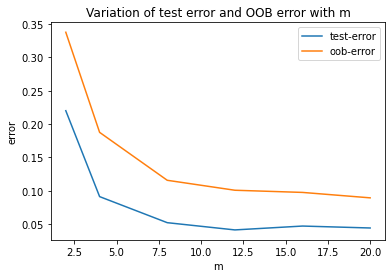

In [25]:
m = [2, 4, 8, 12, 16, 20]
te, oobe = [], []
for max_features in m:
    rf = RandomForest(n_estimators=50, max_samples=0.2, max_features=max_features, impurity_measure='entropy')
    rf.fit(training_data)
    acc = rf.score(X_test, y_test)
    te.append(1-acc)
    oobe.append(1-rf.oob_score)
    print("Test Accuracy: %.4f " % acc)
    print("Test Error: %.4f " % (1-acc))
    print('OOB Error: %.4f' % (1-rf.oob_score))

fig, ax = plt.subplots()
ax.plot(m, te, label='test-error')
ax.plot(m, oobe, label='oob-error')
ax.set_xlabel('m')
ax.set_ylabel('error')
ax.set_title("Variation of test error and OOB error with m")
ax.legend()

#### **Observations**

1. Code reuse has been done for the Decision Tree Classifier from the assignment-1. Random Forest Classifier makes use of this code with some minor changes to create a forest of trees which has been used to make predictions on the test set.

2. As not all the hyperparameters has been used in the custom implementation of the random forest as well as the decision tree, so I am supposing that is why the initial performance of the algorithm on very low values of estimators and max_features used, shows a significant difference in the test set accuracies with respect to the random forest implementation provided by scikit-learn.

3. Most importantly, as the number of max_features (m) selected at random for finding the best split is increased, the implemented algorithm starts giving a significant boost in the performance and comparable results with respect to the scikit learn implementation of the same algorithm.

4. As suggested by the slides in the lectues, major m values corresponds to sqrt(m)/2, sqrt(m), 2\*sqrt(m) values and somewhere around the same range. These values show a good performance as the number increases till a point and when combined with other hyper parameters, shows a very good performance on the test set.

5. Sensitivity of random forests to the paramter m is shown above in the experiments as well as in the plotted graph which also shows OOB error and test error for different values of m.

6. With the increase in the values of m, both OOB error and test error seems to decrease but the best performing model is observed at mentioned below params:</br>
    **n_estimators: 50, max_samples: 0.2, max_features: 16, impurity_measure: entropy with 96.37% accuracy on the test set.** </br>The whole experimentation is shown above.
    Though there are many models with maybe lesser values of errors but to my understanding, the best model should be a blend of all three values i,e, large accuracy, least test and oob errors.
    
7. Inbuilt version of the classifier in scikit-learn is a lot faster than the implemented version. Making use of multiprocessing module and more optimized set of functions can make the implemented version faster.